# EJERCICIO

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
import joblib
import warnings

In [74]:
warnings.filterwarnings("ignore", category=FutureWarning)
set_config(display="diagram")

## DEFINICIÓN DEL PROBLEMA

**Vamos a trabajar con un dataframe sobre los datos del titanic que viene en la librería seaborn para intentar predecir si una persona sobrevivió o no a partir del resto de atributos.**

**Como criterio de evaluación vamos a usar la exactitud (accuracy), que mide la proporción de predicciones correctas realizadas por el modelo.**

## RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

### OBTENER LOS DATOS

In [75]:
df_titanic = sns.load_dataset('titanic')

En el conjunto de datos Titanic, cada columna proporciona información específica sobre los pasajeros del Titanic.

1. `survived`: Esta columna indica si un pasajero sobrevivió o no al naufragio del Titanic. Tiene dos valores posibles: 0 (no sobrevivió) y 1 (sobrevivió).

2. `pclass`: Representa la clase de pasaje del pasajero en el Titanic. Tiene tres valores posibles: 1 (primera clase), 2 (segunda clase) y 3 (tercera clase).

3. `sex`: Indica el género del pasajero, ya sea masculino o femenino.

4. `age`: Representa la edad del pasajero en años.

5. `sibsp`: Indica el número de hermanos o cónyuges que el pasajero tenía a bordo del Titanic.

6. `parch`: Representa el número de padres o hijos que el pasajero tenía a bordo del Titanic.

7. `fare`: Indica la tarifa que el pasajero pagó por su pasaje.

8. `embarked`: Representa el puerto de embarque del pasajero. Tiene tres valores posibles: "C" (Cherbourg), "Q" (Queenstown) y "S" (Southampton).

9. `class`: Similar a `pclass`, pero se expresa en palabras en lugar de números.

10. `who`: Indica si el pasajero es un niño (child), hombre (man) o mujer (woman).

11. `adult_male`: Indica si el pasajero es adulto y masculino.

12. `deck`: Representa la cubierta en la que se encontraba la cabina del pasajero (si es que se encontraba en cubierta).

13. `embark_town`: El nombre de la ciudad o localidad correspondiente al puerto de embarque.

14. `alive`: Indica si el pasajero está vivo o muerto. Similar a `survived`, pero se expresa como "yes" (sí) o "no" (no).

15. `alone`: Indica si el pasajero viajaba solo (True) o con compañía (False).

### EXPLORAR LOS DATOS

Muestra las primeras líneas del dataframe

In [76]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


¿Cuántas columnas hay? ¿De que tipo? ¿Cuántos valores no nulos tiene cada columna?

In [77]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Elimina las columnas innecesarias:
- `class`: la información está también en pclass
- `who`: con sex y age se obtiene la información
- `adult_male`: con sex y age se obiene la información
- `deck`: tiene muchos valores nulos y es díficil decidir que valor dar a los valores ausentes
- `embark_town`: la información está también en embarked
- `alive`: la información está también en survived
- `alone`: con sibsp y parch se obtiene la información

In [78]:
columnas = ['class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
df_titanic = df_titanic.drop(columns=columnas, axis=1)
print(df_titanic.columns.tolist())

['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


Muestra las estadísticas básicas de los atributos numéricos

In [79]:
import pandas as pd


columnas_numericas = df_titanic.select_dtypes(include=['int64', 'float64']).columns

print(df_titanic[columnas_numericas].describe())

         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


Muestra las estadísticas descriptivas de los atributos categóricos (con el parametro include)

In [80]:
import pandas as pd


columnas_categoricas = df_titanic.select_dtypes(include=['object', 'category']).columns

print(df_titanic[columnas_categoricas].describe())

         sex embarked
count    891      889
unique     2        3
top     male        S
freq     577      644


Respresenta los atributos en un histograma o diagrama de barras para ver sus distribuciones: 
- usa seaborn
- dibuja los ochos en un mismo grafico con 8 subgrafos (4x2)
- usa counplot de seaborn para las variables categoricas o discretas
- usa histplot de seaborn para las variables continuas

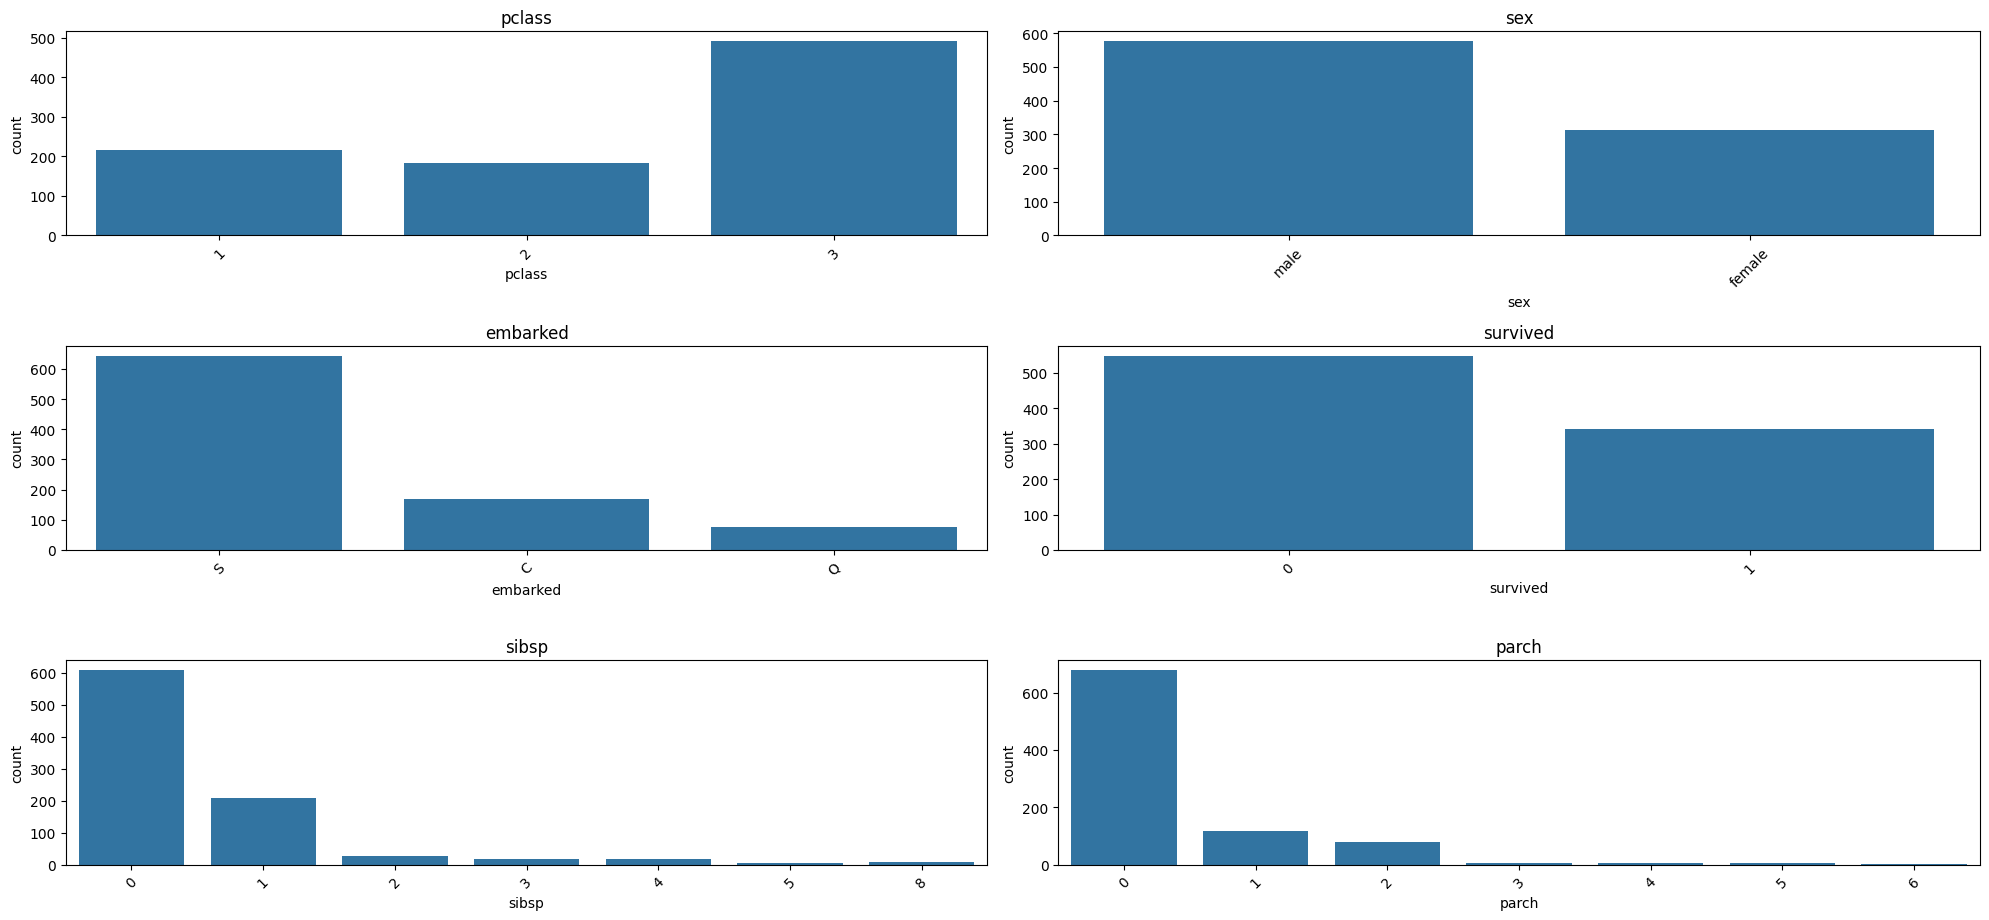

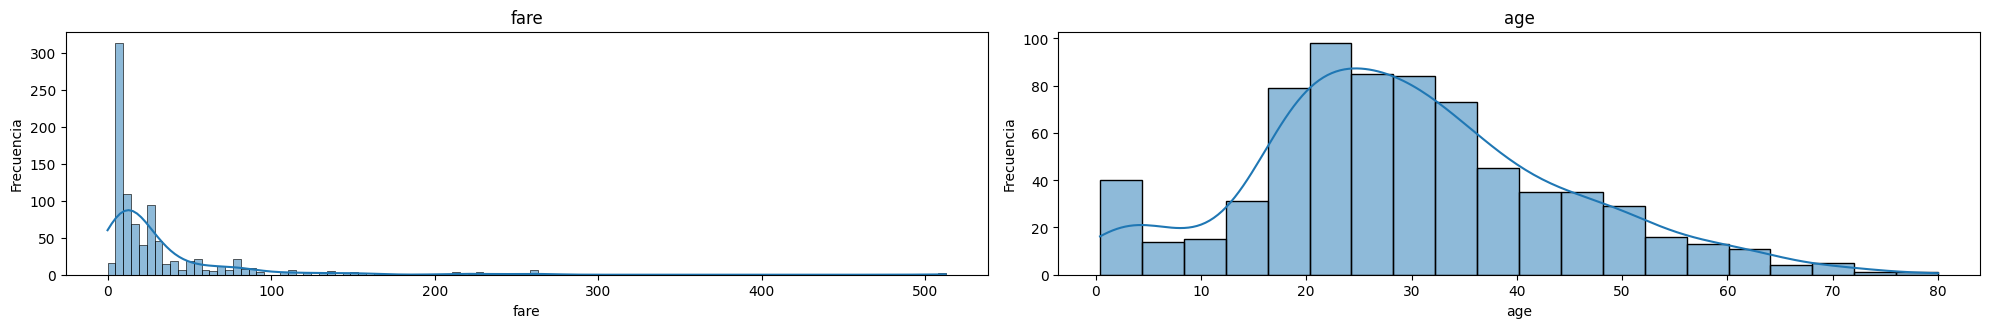

In [81]:
categoricas = ['pclass', 'sex', 'embarked', 'survived','sibsp','parch']  
continuas = ['fare','age']  

# Gráfico de barras para variables categóricas
plt.figure(figsize=(20, 12))
for i, var in enumerate(categoricas):
    plt.subplot(4, 2, i+1)
    sns.countplot(x=var, data=df_titanic)
    plt.title(f'{var}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Gráfico de histograma para variables continuas
plt.figure(figsize=(20, 12))
for i, var in enumerate(continuas):
    plt.subplot(4, 2, i+1)
    sns.histplot(df_titanic[var], kde=True)
    plt.title(f'{var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

¿A la vista de los datos que conclusiones puedes sacar?

Conclusiones 🤔: A la vista de los datos, podemos afirmar que hay claramente más hombres que mujeres en el dataset, casi el doble, seguramente la mayoría de mujeres iban acompañadas de un hombre, la mayoría embarcaron en Southhampton, y los que menos en Queenstown. En el gráfico pclass podemos ver las tres clases, como es de esperar, en 3a clase es donde van la mayoría de pasajeros, esto se complementa con el gráfico de fare, ya que se ve que la mayoría de pasajeros pagan menos. Con el gráfico de edad podemos concluir que la franja que más habia es de 20 a 35 años. La mayoría de pasajeros viajaban solos y sin hijos. Finalmente vemos que murío bastante más gente de la que sobrevivió.

Muestra la media de supervivientes según el la clase de billete ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [82]:
# Convertir la columna 'survived' a int
df_titanic['survived'] = df_titanic['survived'].astype(int)

# Agrupar por pclass y calcular media de supervivencia
media = df_titanic.groupby('pclass')['survived'].mean().reset_index()

# Crear un nuevo DataFrame con el resultado
resultado_df = pd.DataFrame({
    'pclass': media['pclass'],
    'Media supervivencia': media['survived']
})

# Ordenar de manera descendente
resultado_df = resultado_df.sort_values('Media supervivencia', ascending=False).reset_index(drop=True)

print(resultado_df)

   pclass  Media supervivencia
0       1             0.629630
1       2             0.472826
2       3             0.242363


Conclusiones 🤔: Con estos datos podemos afirmar que a mayor la clase, mayor es la probabilidad de supervivencia. Se puede intuir una correlación entre la clase y la supervivencia.

Muestra la media de supervivientes según el sexo ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [83]:
# Convertir la columna 'survived' a int
df_titanic['survived'] = df_titanic['survived'].astype(int)

# Calcular la media de supervivencia por sexo
media_por_sexo = df_titanic.groupby('sex')['survived'].mean().reset_index()

# Renombrar la columna 'survived' como 'Media supervivencia'
media_por_sexo = media_por_sexo.rename(columns={'survived': 'Media supervivencia'})

# Ordenar de manera descendente
media_por_sexo = media_por_sexo.sort_values('Media supervivencia', ascending=False).reset_index(drop=True)

print(media_por_sexo)


      sex  Media supervivencia
0  female             0.742038
1    male             0.188908


Conclusiones 🤔: La mayoría de supervivientes son mujeres, lo que es lógico sabiendo que las mujeres y los niños fueron los primeros en ser evacuados.

Muestra la media de supervivientes según el número de hermanos y coyúnges ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [84]:
# Convertir la columna 'survived' a int
df_titanic['survived'] = df_titanic['survived'].astype(int)

# Calcular la media de supervivencia por número familiares
media_por_hermanos_coyunges = df_titanic.groupby(['sibsp'])['survived'].mean().reset_index()

# Renombrar las columnas
media_por_hermanos_coyunges.columns = ['Número de familiares', 'Media supervivencia']

# Ordenar de manera descendente
media_por_hermanos_coyunges = media_por_hermanos_coyunges.sort_values('Media supervivencia', ascending=False).reset_index(drop=True)

print(media_por_hermanos_coyunges)


   Número de familiares  Media supervivencia
0                     1             0.535885
1                     2             0.464286
2                     0             0.345395
3                     3             0.250000
4                     4             0.166667
5                     5             0.000000
6                     8             0.000000


Conclusiones 🤔: La probabilidad de supervivencia es mayor cuantos menos familiares tengas abordo.

Muestra la media de supervivientes según el número de padres e hijos ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [85]:

# Convertir la columna 'survived' a int
df_titanic['survived'] = df_titanic['survived'].astype(int)

# Calcular la media de supervivencia por número de padres e hijos (parch)
media_por_padres_hijos = df_titanic.groupby(['parch'])['survived'].mean().reset_index()

# Renombrar las columnas
media_por_padres_hijos.columns = ['Número de padres e hijos', 'Media supervivencia']

# Ordenar de manera descendente
media_por_padres_hijos = media_por_padres_hijos.sort_values('Media supervivencia', ascending=False).reset_index(drop=True)

print(media_por_padres_hijos)


   Número de padres e hijos  Media supervivencia
0                         3             0.600000
1                         1             0.550847
2                         2             0.500000
3                         0             0.343658
4                         5             0.200000
5                         4             0.000000
6                         6             0.000000


Conclusiones 🤔: Pasa lo mismo que en la anterior, cuantos menos padres e hijos más probabilidad de sobrevivir

Halla las correlaciones de los datos numéricos y muestra el coeficiente de correlacion de las diferentes variables respecto a la variable survived

In [86]:
# Solo con los numericos
correlaciones = df_titanic.corr(numeric_only=True)

correlaciones["survived"].sort_values(ascending=False)


survived    1.000000
fare        0.257307
parch       0.081629
sibsp      -0.035322
age        -0.077221
pclass     -0.338481
Name: survived, dtype: float64

Representa la matriz de correlaciones (representa directamente la matriz usando el stilo background_gradient)

In [87]:
correlaciones.style.background_gradient()

,survived,pclass,age,sibsp,parch,fare
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


¿Qué conclusiones sacas de la matriz de correlaciones?

Conclusiones 🤔: Las variables más correlacionadas con survived son pclass y fare, siendo pclass la más correlacionada. Tiene sentido que esté relacionada la clase del billete con la supervivencia

Vamos a seguir explorando los datos haciendo algún gráfico más:

- Grafico de barras para representar el número de supervivientes según la clase de billete y por sexos

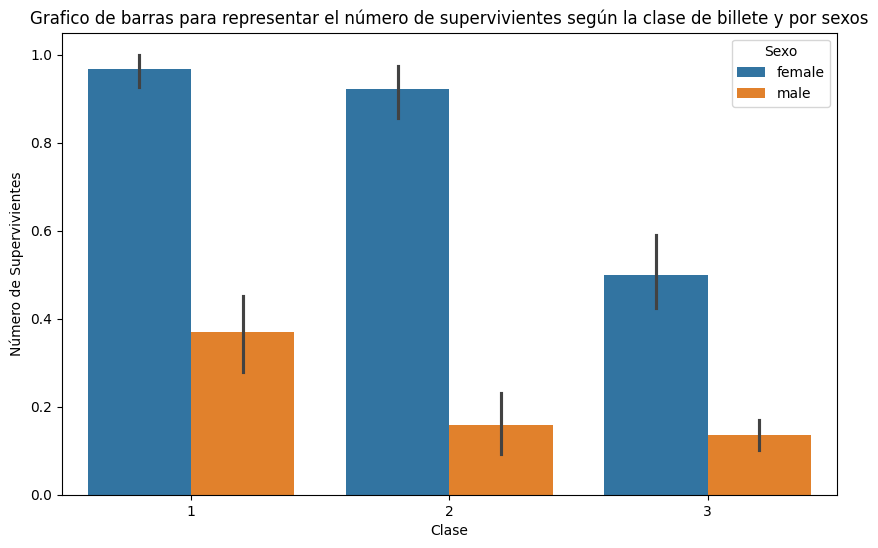

In [88]:

plt.figure(figsize=(10, 6))
sns.barplot(data=df_titanic, x='pclass', y='survived', hue='sex')

# Añadir títulos y etiquetas
plt.title('Grafico de barras para representar el número de supervivientes según la clase de billete y por sexos')
plt.xlabel('Clase')
plt.ylabel('Número de Supervivientes')
plt.legend(title='Sexo')

# Mostrar el gráfico
plt.show()


- Usando FaceGird de seaborn representa los supervivientes según la clase de billete y el puerto de embarque

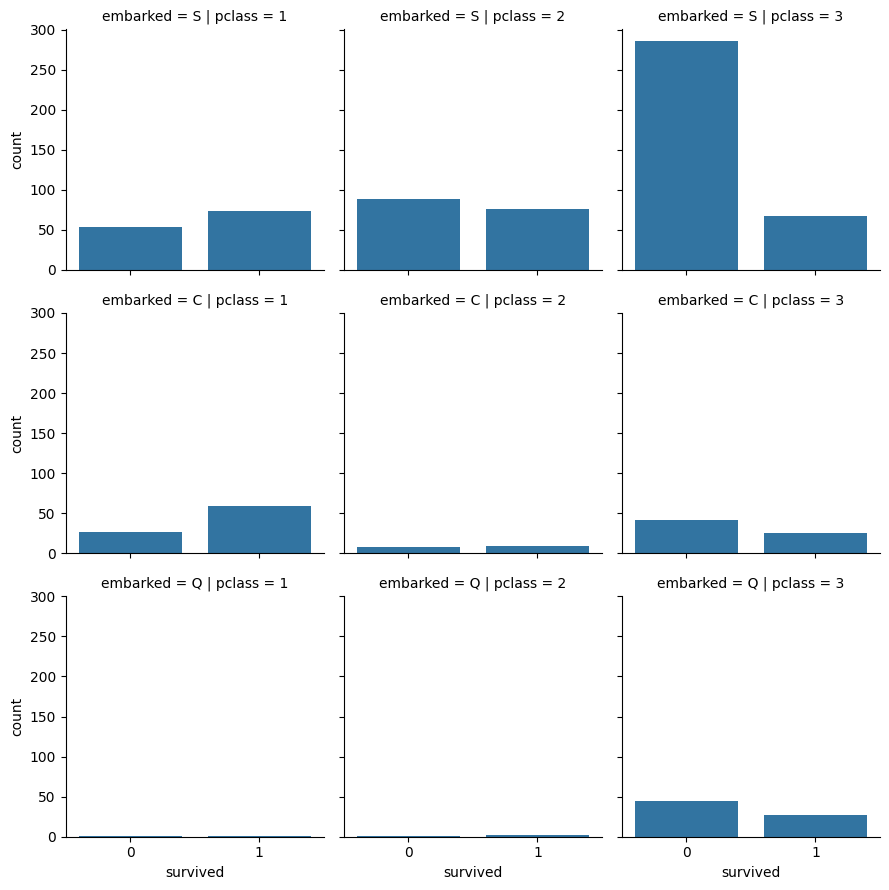

In [89]:
g = sns.FacetGrid(df_titanic, col="pclass", row="embarked")
g.map(sns.countplot, "survived", order=[0, 1])

plt.show()

### DIVIDIR LOS DATOS

Es hora de separar el conjunto de entrenamiento del conjunto de prueba (85% para el entrenamiento y haciendo un muestreo estratificado según la clase del billete, que parece que es una de las más correlacionada con la carracteristica survived y hay bastante más pasajeros de clase 3 que de clase 1 y2).

Haz una copia del conjunto de entrenamiento para trabajar con él.

In [90]:
df_entrenamiento, df_testing = train_test_split(df_titanic, test_size=0.15, stratify=df_titanic["pclass"], random_state=3)
df_entrenamiento_copia = df_entrenamiento.copy()


### PREPARAR LOS DATOS

Hay que crear un pipeline de transformación que haga los siguientes cambios:
- pclass: 
  - rellenar datos faltantes con la moda
- sex:
  - rellenar datos faltantes con la moda
  - convertir male a 0 y female a 1
- age:
  - rellenar datos faltantes con la media
  - convertirla en variable categórica:
      - 1 - <=16
      - 2 - (16,32]
      - 3 - (32,48]
      - 4 - (48,64]
      - 5 - >64)
- family = sibsp + parch
  - rellenar datos faltantes con la moda
  - sumar las dos columnas
- fare
  - rellenar datos faltantes con la media
  - aplicar raiz cuadrada
  - estandarizar
- embarked
  - rellenar datos faltantes con la moda
  - aplicar one-hot

Pero vamos a empezar poco a poco

Crea el atributo familia como suma de sibsp y parch y luego borra sibsp y parch

In [ ]:
# Nuevo atributo familia
df_entrenamiento_copia['familia'] = df_entrenamiento_copia['sibsp'] + df_entrenamiento_copia['parch']

# Eliminar las columnas
df_entrenamiento_copia.drop(columns=['sibsp', 'parch'], inplace=True)

Rellenamos los datos ausentes en el dataframe (lo hacemos para todas las columnas aunque ahora la mayoría no tiene datos ausentes, pero no sabemos como serán los datos si tenemos que volver a entrenar el modelo)

In [92]:
columnas_categoricas = ['pclass', 'sex', 'familia', 'embarked']
columnas_numericas = ['age', 'fare']

llenar_categorico = SimpleImputer(strategy='most_frequent')
df_entrenamiento_copia[columnas_categoricas] = llenar_categorico.fit_transform(df_entrenamiento_copia[columnas_categoricas])

llenar_numerico = SimpleImputer(strategy='mean')
df_entrenamiento_copia[columnas_numericas] = llenar_numerico.fit_transform(df_entrenamiento_copia[columnas_numericas])


En el columna sex sustituir male por 0 y female por 1

In [ ]:
df_entrenamiento_copia['sex'] = df_entrenamiento_copia['sex'].replace({'male': 0, 'female': 1})


Aplicar One-Hot a la columna embarked

In [ ]:
# Inicializar el encoder
encoder = OneHotEncoder( sparse_output=False)

# Aplicar el encoder y crear un DataFrame con los resultados
encoded_columns = encoder.fit_transform(df_entrenamiento_copia[['embarked']])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['embarked']))

# Concatenar el DataFrame codificado con el DataFrame original y eliminar la columna original
df_entrenamiento_copia = pd.concat([df_entrenamiento_copia.drop(columns=['embarked']), encoded_df], axis=1)

Convertir la variable age en una variable categórica: 
- 1 - <=16
- 2 - (16,32]
- 3 - (32,48]
- 4 - (48,64]
- 5 - >64)

In [ ]:
df_entrenamiento_copia['age'] = pd.cut(df_entrenamiento_copia['age'], bins=[-np.inf, 16, 32, 48, 64, np.inf], labels=[1, 2, 3, 4, 5])

Como la columna fare tiene una cola larga por la derecha y tiene valores que son cero aplica la raiz cuadrada a la variable

In [ ]:
df_entrenamiento_copia['fare'] = np.sqrt(df_entrenamiento_copia['fare'])

Estandarizar la variable fare

In [97]:
scaler = StandardScaler()
df_entrenamiento_copia[['fare']] = scaler.fit_transform(df_entrenamiento_copia[['fare']])

Ya esta el dataframe con los datos de entrenamiento preparados, pero los cambios hechos también hay que hacerlos en los datps de prueba a y en un futuro en otros dataframe bien para entrenar de nuevo el modelo, bien para predecir datos. Por lo tanto, hay que crear una pipeline a la que le pasamos el dataframe y haga todos los cambios.

In [ ]:
# Creo nombres para poder llamar a feature names
def familia_name(function_transformer, feature_names_in):
     return ['familia']
# juntar parch y sibsp para familia
def crearFamilia(X):
     X=pd.DataFrame(X,columns=['parch','sibsp'])
     X['familia'] = X['sibsp'] + X['parch'] 
     return X['familia'].values.reshape(-1,1)

def age_name(function_transformer, feature_names_in):
     return ['age']
def separar_age(X):
     X=pd.DataFrame(X,columns=['age'])
     X['age'] = pd.cut(X['age'], bins=[-1,16,32,48,64,np.inf], labels=[1,2,3,4,5]).to_numpy().reshape(-1,1)  
     return X

def formatearSex(function_transformer, feature_names_in):
     return ['sex']
#male 0 female 1
def sexNumeros(X):
     return np.where(X == 'female',1,0)

pclass_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent')  
)

familia_pipeline = make_pipeline(
     SimpleImputer(strategy='most_frequent'),
     FunctionTransformer(crearFamilia,feature_names_out=familia_name,validate=False)
)
age_pipeline=make_pipeline(
     SimpleImputer(strategy='mean'),
     FunctionTransformer(separar_age,feature_names_out=age_name)
)

sex_pipeline=make_pipeline(
     SimpleImputer(strategy="most_frequent"), 
     FunctionTransformer(sexNumeros,feature_names_out=formatearSex)
)

embarked_pipeline = make_pipeline(
     SimpleImputer(strategy="most_frequent"), 
     OneHotEncoder(handle_unknown="ignore")
)

fare_pipeline = make_pipeline(
     SimpleImputer(strategy="mean"),
     FunctionTransformer(np.sqrt, feature_names_out="one-to-one"),
     StandardScaler()
)

pipeline_titanic = ColumnTransformer([
     ('pclass', pclass_pipeline, ['pclass']), 
     ('sex', sex_pipeline, ['sex']),
     ('age', age_pipeline, ['age']), 
     ('familia', familia_pipeline,['sibsp', 'parch']), 
     ('fare',fare_pipeline, ['fare']), 
     ('embarked', embarked_pipeline, ['embarked']) 
 ],
 remainder='passthrough',verbose_feature_names_out=False
 )

transformado = pipeline_titanic.fit_transform(df_entrenamiento)

# Obtener nombres de las características finales
feature_names = pipeline_titanic.get_feature_names_out()

# Crear el DataFrame final
df_final = pd.DataFrame(transformado, columns=feature_names)

# Mostrar el resultado
print(df_final.head())


   pclass  sex  age  familia      fare  embarked_C  embarked_Q  embarked_S  \
0     1.0  1.0  4.0      2.0  1.649346         0.0         0.0         1.0   
1     1.0  0.0  2.0      1.0  1.911360         1.0         0.0         0.0   
2     1.0  0.0  3.0      0.0  0.104286         0.0         0.0         1.0   
3     3.0  1.0  2.0      0.0 -0.705992         0.0         1.0         0.0   
4     3.0  0.0  2.0      2.0 -0.322639         1.0         0.0         0.0   

   survived  
0       1.0  
1       0.0  
2       1.0  
3       1.0  
4       1.0  


## ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Vamos a probar varios algoritmos para ver cual es el que mejor va, para ello primero vamos a evaluarlos manualmente y luego ya utilizaremos validación cruzada.

En concreto vamos a probar:
- Regresión logística
- Random Forest
- KNN (K - Nearest Neighbors)

Cuanto más se acerque a 1 la exactitud (accuracy), mejor será el modelo.

### REGRESIÓN LOGÍSTICA
Pasos a seguir:
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de entrenamiento
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de test
- Crear el modelo (modelo = LogisticRegression())
- Entrenar el modelo
- Calcular la precisión para el conjunto de entrenamiento (usa accuracy_score)
- Calcular la precisión para el conjunto de test 

In [99]:
# En la X las caracteristicas y en la Y lo que quiero testear
x_entrenamiento = df_entrenamiento.drop('survived', axis=1)
y_entrenamiento = df_entrenamiento['survived']

# Lo mismo para test
x_test = df_testing.drop('survived', axis=1)
y_test = df_testing['survived']

modelo_reg = make_pipeline(pipeline_titanic,LogisticRegression())
modelo_reg.fit(x_entrenamiento, y_entrenamiento)
y_entrenamiento_prueba = modelo_reg.predict(x_entrenamiento)
y_test_prueba = modelo_reg.predict(x_test)

aciertos_entrenamiento_rl = accuracy_score(y_entrenamiento, y_entrenamiento_prueba)
aciertos_test_rl = accuracy_score(y_test, y_test_prueba)

print(f'Precisión en el conjunto de entrenamiento: {aciertos_entrenamiento_rl:.2f}')
print(f'Precisión en el conjunto de prueba: {aciertos_test_rl:.2f}')

Precisión en el conjunto de entrenamiento: 0.81
Precisión en el conjunto de prueba: 0.78


### RANDOM FOREST
Hacemos lo mismo pero ahora usando el algoritmo Random Forest (RandomForestClassifier(n_estimators=100))

In [100]:

modelo_rand = make_pipeline(pipeline_titanic,RandomForestClassifier(n_estimators=100))
modelo_rand.fit(x_entrenamiento, y_entrenamiento)
y_entrenamiento_prueba = modelo_rand.predict(x_entrenamiento)
y_test_prueba = modelo_rand.predict(x_test)

aciertos_entrenamiento_r = accuracy_score(y_entrenamiento, y_entrenamiento_prueba)
aciertos_test_r = accuracy_score(y_test, y_test_prueba)

print(f'Precisión en el conjunto de entrenamiento: {aciertos_entrenamiento_r:.2f}')
print(f'Precisión en el conjunto de prueba: {aciertos_test_r:.2f}')

Precisión en el conjunto de entrenamiento: 0.95
Precisión en el conjunto de prueba: 0.81


### K - NEAREST NEIGHBORS
Hacemos lo mismo pero ahora usando el algoritmo K - Nearest Neighbours (KNeighborsClassifier(n_neighbors=3))

In [101]:

modelo_k = make_pipeline(pipeline_titanic,KNeighborsClassifier(n_neighbors=3))
modelo_k.fit(x_entrenamiento, y_entrenamiento)
y_entrenamiento_prueba = modelo_k.predict(x_entrenamiento)
y_test_prueba = modelo_k.predict(x_test)

aciertos_entrenamiento_k = accuracy_score(y_entrenamiento, y_entrenamiento_prueba)
aciertos_test_k = accuracy_score(y_test, y_test_prueba)

print(f'Precisión en el conjunto de entrenamiento: {aciertos_entrenamiento_k:.2f}')
print(f'Precisión en el conjunto de prueba: {aciertos_test_k:.2f}')

Precisión en el conjunto de entrenamiento: 0.88
Precisión en el conjunto de prueba: 0.79


### COMPARACIÓN

Muestra una tablas con los resultado obtenidos


| Modelo                 |Precisión entrenamiento   | Precisión test  |
|------------------------|--------------------------|-----------------|
| LogisticRegression     |                          |                 |
| RandomForestClassifier |                          |                 |
| KNeighborsClassifier   |                          |                 |

In [102]:
resultados = pd.DataFrame({
    "Modelo": ["LogisticRegression", "RandomForestClassifier", "KNeighborsClassifier"],
    "Precisión entrenamiento": [aciertos_entrenamiento_rl, aciertos_entrenamiento_r, aciertos_entrenamiento_k],
    "Precisión test": [aciertos_test_rl, aciertos_test_r, aciertos_test_k]
})
print(resultados)

                   Modelo  Precisión entrenamiento  Precisión test
0      LogisticRegression                 0.807133        0.776119
1  RandomForestClassifier                 0.945839        0.805970
2    KNeighborsClassifier                 0.878468        0.791045


A la vista de los resultados con ¿cual te quedas para trabajarlo con validación cruzada y luego optimizarlo?

Conclusiones 🤔: Me quedo con Random forest, que es la que mejor resultado me da.

Vamos a usar RandomForestClassifier con validación cruzada

In [103]:
random_forest_cruzada = cross_val_score(modelo_rand, x_entrenamiento, y_entrenamiento, cv=5, scoring='accuracy')
print(f"RMSE con validación cruzada {np.mean(random_forest_cruzada):.2f}")

RMSE con validación cruzada 0.81


## OPTIMIZACIÓN DEL MODELO

Vamos a optimizar el modelo usando busqueda aleatorio para optimizar los hiperparametros, en concreto vamos a mejorar los siguientes hiperparametros
``````
param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}
``````

In [104]:
# Crear un pipeline con make_pipeline
pipeline = make_pipeline(pipeline_titanic,RandomForestClassifier())

param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

# Crear el objeto de búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, scoring='accuracy', cv=5)

# Ajustar el modelo a los datos de entrenamiento
random_search.fit(x_entrenamiento, y_entrenamiento)

# Mejor estimador encontrado
print("Mejores hiperparámetros encontrados:", random_search.best_params_)


Mejores hiperparámetros encontrados: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 153}


### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

EvaluaR el modelo usando accuracy_score y el conjunto de datos de test

In [105]:
# con la nueva pipeline
# Crear y entrenar modelo
modelo = pipeline.fit(x_entrenamiento, y_entrenamiento)

# Calcular aciertos con datos de entrenamiento
aciertos_entrenamiento = accuracy_score(y_entrenamiento, modelo.predict(x_entrenamiento))
print(f"Aciertos con datos de entrenamiento: {aciertos_entrenamiento:.2f}")

# Calcular aciertos con datos de prueba
aciertos_pruebas = accuracy_score(y_test, modelo.predict(x_test))
print(f"Aciertos con datos de prueba: {aciertos_pruebas:.2f}")

Aciertos con datos de entrenamiento: 0.95
Aciertos con datos de prueba: 0.81


## PRESENTACIÓN DE LA SOLUCIÓN

Ahora tienes que crear un archivo .py con todo lo necesario para que ejecute el modelo que acabamos de crear, en concreto el script tiene que ejecutar lo siguiente:
- Pedir un csv para predecir los datos (suponemos que los datos en el csv están bien)
- Cargamos los datos del csv en un dataframe.
- Aplicamos nuestro modelo al dataframe.
- Informamos al usuario de las predicciones.

In [106]:
joblib.dump(modelo, "./modelo.pkl")

['./modelo.pkl']